# General features of ATAC-seq peaks

## Load libraries/functions

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r'\boldmath',r'\usepackage{amsmath}',r'\usepackage{amssymb}']
from matplotlib.pyplot import cm

import scipy

import itertools
from collections import Counter

from scipy.stats.stats import pearsonr 
from scipy.stats import fisher_exact, hypergeom

from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from adjustText import adjust_text

import gc

/home/andrew/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  import sys


## Load data

In [2]:
data_dir = '../data'

atac_file = 'ATACseq-CQN-preprocessed-norm-counts.tsv' # note these are log2(x+1) values, and account for GC content and peak-width

fimo_file = 'organoids-ATACseq-JASPAR2020ext-fimo-raw.txt'

# rna-seq files #
rna_file = 'RNAseq-DEseq2-preprocessed-norm-counts.tsv'
rna_clusters_file = 'organoid_gene_clusters_consensus_boolean.csv'

# TAD boundaries #
tad_file = 'TADs-interTADs_mESC.Bonev_2017.bed'

#
tf_database_file = '/home/andrew/biology/xdf/projects/utils/TF_lists/Mus_musculus_TF.txt'

In [3]:
# -- load atac peak counts -- #
atac_df = pd.read_csv(data_dir+'/'+atac_file, sep='\t')
print(atac_df.shape)

# remove peaks overlapping with exons
bool_exon = atac_df['context'] != 'exon'
atac_df = atac_df[:][bool_exon]

# add peak width as features
atac_df['peak-width'] = atac_df['chromEnd'] - atac_df['chromStart']

print(atac_df.shape)
print(atac_df.columns)

atac_df['chromEnd']   = atac_df['chromEnd'].astype(int)
atac_df['chromStart'] = atac_df['chromStart'].astype(int)

(361867, 14)
(333960, 15)
Index(['Unnamed: 0', 'D0', 'D1', 'D2', 'D3', 'D5_GFPminus', 'D5_GFPplus',
       'chrom', 'chromStart', 'chromEnd', 'context', 'nearest_gene_ensemble',
       'nearest_gene_id', 'tad-id-bonev', 'peak-width'],
      dtype='object')


In [4]:
## ---------------------  ##
## -- load RNAseq data -- ##
## ---------------------- ##
rna_df = pd.read_csv(data_dir+'/'+rna_file, sep='\t')

rna_df['day0'] = rna_df[['Day0_1','Day0_2','Day0_3']].mean(axis=1)
rna_df['day1'] = rna_df[['Day1_1','Day1_2','Day1_3']].mean(axis=1)
rna_df['day2'] = rna_df[['Day2_1','Day2_2','Day2_3']].mean(axis=1)
rna_df['day3'] = rna_df[['Day3_1','Day3_2','Day3_3']].mean(axis=1)
rna_df['day4-gfpneg'] = rna_df[['Day4_GFPneg_1','Day4_GFPneg_2','Day4_GFPneg_3']].mean(axis=1)
rna_df['day4-gfppos'] = rna_df[['Day4_GFPpos_1','Day4_GFPpos_2','Day4_GFPpos_3']].mean(axis=1)
rna_df['day5-gfpneg'] = rna_df[['Day5_GFPneg_1','Day5_GFPneg_2','Day5_GFPneg_3']].mean(axis=1)
rna_df['day5-gfppos'] = rna_df[['Day5_GFPpos_1','Day5_GFPpos_2','Day5_GFPpos_3']].mean(axis=1)

## add clusters metadata ##
rna_clusters_df = pd.read_csv(data_dir+'/'+rna_clusters_file, sep=',')
rna_clusters_df = rna_clusters_df.drop(['Unnamed: 0'],axis=1)
rna_df = rna_df.join(rna_clusters_df)

print(rna_df.columns, rna_df.shape)

Index(['Unnamed: 0', 'ext_gene', 'ens_gene', 'chrom', 'chromStart', 'chromEnd',
       'strand', 'Day0_1', 'Day0_2', 'Day0_3', 'Day1_1', 'Day1_2', 'Day1_3',
       'Day2_1', 'Day2_2', 'Day2_3', 'Day3_1', 'Day3_2', 'Day3_3',
       'Day4_GFPneg_1', 'Day4_GFPneg_2', 'Day4_GFPneg_3', 'Day4_GFPpos_1',
       'Day4_GFPpos_2', 'Day4_GFPpos_3', 'Day5_GFPneg_1', 'Day5_GFPneg_2',
       'Day5_GFPneg_3', 'Day5_GFPpos_1', 'Day5_GFPpos_2', 'Day5_GFPpos_3',
       'EF-up', 'EF-down', 'D0-D1-up', 'D0-D1-down', 'D1-D2-up', 'D1-D2-down',
       'D2-D3-up', 'D2-D3-down', 'HK', 'tad-id-bonev', 'day0', 'day1', 'day2',
       'day3', 'day4-gfpneg', 'day4-gfppos', 'day5-gfpneg', 'day5-gfppos',
       'cluster-0', 'cluster-1', 'cluster-2', 'cluster-3', 'cluster-4',
       'cluster-5'],
      dtype='object') (49705, 55)


In [5]:
## load Mus musculus TF list
tf_list_df = pd.read_csv(tf_database_file,sep='\t')
tf_list = tf_list_df['Symbol'].tolist()
print(len(tf_list))

ef_up_tfs   = rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['EF-up']].tolist()
ef_down_tfs = rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['EF-down']].tolist()

## number of up and down-regulated genes that are TFs ##
print('EF up TFs:  ', len(ef_up_tfs), 'of', rna_df['EF-up'].sum())
print('EF down TFs:', len(ef_down_tfs), 'of', rna_df['EF-down'].sum())

d2d3_up_tfs   = rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['D2-D3-up']].tolist()
d2d3_down_tfs = rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['D2-D3-down']].tolist()
print('D2-D3 TFs:' ,len(d2d3_up_tfs), len(d2d3_down_tfs))

1636
EF up TFs:   11 of 37
EF down TFs: 65 of 453
D2-D3 TFs: 31 10


In [6]:
# ef_up_tad_numbers = sorted(list(set(rna_df['tad-id-bonev'][rna_df['liusaidh-EF-up']])))
ef_up_tad_numbers = sorted(list(set(rna_df['tad-id-bonev'][rna_df['EF-up']])))
ef_up_tad_numbers = list(filter(lambda a: a != -1, ef_up_tad_numbers))
print(len(ef_up_tad_numbers))

ef_down_tad_numbers = sorted(list(set(rna_df['tad-id-bonev'][rna_df['EF-down']])))
ef_down_tad_numbers = list(filter(lambda a: a != -1, ef_down_tad_numbers))
print(len(ef_down_tad_numbers))

bool_ef_up_peak_selection   = atac_df['tad-id-bonev'].isin(ef_up_tad_numbers)
bool_ef_down_peak_selection = atac_df['tad-id-bonev'].isin(ef_down_tad_numbers)

ef_up_peak_tads = sorted(list(atac_df['tad-id-bonev'][bool_ef_up_peak_selection]))
ef_down_peak_tads = sorted(list(atac_df['tad-id-bonev'][bool_ef_down_peak_selection]))
print(len(ef_up_peak_tads), len(ef_down_peak_tads))

28
326
4339 47812


## Define set of lineage defining peaks

In [7]:
#################################################
### define a set of genome-wide dynamic peaks ###
#################################################

## --- log2fc for CQN normalized values
log2fc_35m  = atac_df['D5_GFPminus'] - atac_df['D3']
log2fc_35p  = atac_df['D5_GFPplus'] - atac_df['D3']
log2fc_5p5m = atac_df['D5_GFPplus'] - atac_df['D5_GFPminus']


# take max over days
max_bp_access = atac_df[['D0', 'D1', 'D2', 'D3','D5_GFPminus', 'D5_GFPplus']]
max_bp_access = np.max(max_bp_access,axis=1)
#
max_bp_access_35p = atac_df[['D3', 'D5_GFPplus']]
max_bp_access_35p = np.max(max_bp_access_35p,axis=1)
#
max_bp_access_5p5m = atac_df[['D5_GFPminus', 'D5_GFPplus']]
max_bp_access_5p5m = np.max(max_bp_access_5p5m,axis=1)


fc_thr = 1.5
bp_access_thr = np.percentile(max_bp_access,10)

bool_up_peaks_35p   = ((log2fc_35p >   fc_thr) & (max_bp_access_35p  > bp_access_thr)) \
                    & ((log2fc_5p5m >  fc_thr) & (max_bp_access_5p5m > bp_access_thr))
bool_down_peaks_35p = ((log2fc_35p  < -fc_thr) & (max_bp_access_35p  > bp_access_thr)) \
                    & ((log2fc_5p5m < -fc_thr) & (max_bp_access_5p5m > bp_access_thr))
print(bool_up_peaks_35p.sum(), bool_down_peaks_35p.sum())

7782 53


## How many EF TAD peaks are dynamic (across trajectory comparisons)

In [8]:
bool_dynamic_ef_up_peaks   = bool_up_peaks_35p
bool_dynamic_ef_down_peaks = bool_down_peaks_35p

bool_promoter    = (atac_df['context'] == 'promoter')
bool_nonpromoter = (atac_df['context'] != 'promoter')
# bool_EFup_peaks = atac_df['tad-id-bonev'].isin(ef_up_tad_numbers)
bool_EFup_peaks       = bool_ef_up_peak_selection
bool_EFup_promoter    = bool_EFup_peaks & bool_promoter
bool_EFup_nonpromoter = bool_EFup_peaks & bool_nonpromoter
#bool_EFdown_peaks = atac_df['tad-id-bonev'].isin(ef_down_tad_numbers)
bool_EFdown_peaks = bool_ef_down_peak_selection
bool_EFdown_promoter    = bool_EFdown_peaks & bool_promoter
bool_EFdown_nonpromoter = bool_EFdown_peaks & bool_nonpromoter

## breakdown of dynamic peaks (EF TADs)
bool_EFup_dynamic_promoter      = bool_EFup_promoter & (bool_up_peaks_35p | bool_down_peaks_35p)
bool_EFup_dynamic_nonpromoter   = bool_EFup_nonpromoter & (bool_up_peaks_35p | bool_down_peaks_35p)
bool_EFdown_dynamic_promoter    = bool_EFdown_promoter & (bool_up_peaks_35p | bool_down_peaks_35p)
bool_EFdown_dynamic_nonpromoter = bool_EFdown_nonpromoter & (bool_up_peaks_35p | bool_down_peaks_35p)
n_EFup_dynamic_promoter    = bool_EFup_dynamic_promoter.sum()
n_EFup_dynamic_nonpromoter = bool_EFup_dynamic_nonpromoter.sum()
n_EFup_dynamic_all = n_EFup_dynamic_promoter + n_EFup_dynamic_nonpromoter
n_EFdown_dynamic_promoter    = bool_EFdown_dynamic_promoter.sum()
n_EFdown_dynamic_nonpromoter = bool_EFdown_dynamic_nonpromoter.sum()
n_EFdown_dynamic_all = n_EFdown_dynamic_promoter + n_EFdown_dynamic_nonpromoter


# breakdown of all dynamic peaks
n_dynamic_up_peaks   = bool_up_peaks_35p.sum()
n_dynamic_down_peaks = bool_down_peaks_35p.sum()
n_dynamic_up_promoters   = (bool_up_peaks_35p & bool_promoter).sum()
n_dynamic_down_promoters = (bool_down_peaks_35p & bool_promoter).sum()
n_dynamic_up_nonpromoters   = (bool_up_peaks_35p & bool_nonpromoter).sum()
n_dynamic_down_nonpromoters = (bool_down_peaks_35p & bool_nonpromoter).sum()

# breakdown of EF-up TAD peaks # 
n_EFup_peaks = bool_EFup_peaks.sum()
n_EFup_up_peaks   = (bool_EFup_peaks & bool_dynamic_ef_up_peaks).sum()
n_EFup_down_peaks = (bool_EFup_peaks & bool_dynamic_ef_down_peaks).sum()
n_EFup_up_promoters   = (bool_EFup_promoter & bool_dynamic_ef_up_peaks).sum()
n_EFup_down_promoters = (bool_EFup_promoter & bool_dynamic_ef_down_peaks).sum()
n_EFup_up_nonpromoters   = (bool_EFup_nonpromoter & bool_dynamic_ef_up_peaks).sum()
n_EFup_down_nonpromoters = (bool_EFup_nonpromoter & bool_dynamic_ef_down_peaks).sum()

# breakdown of EF-down TAD peaks # 
n_EFdown_peaks = bool_EFdown_peaks.sum()
n_EFdown_up_peaks   = (bool_EFdown_peaks & bool_dynamic_ef_up_peaks).sum()
n_EFdown_down_peaks = (bool_EFdown_peaks & bool_dynamic_ef_down_peaks).sum()
n_EFdown_up_promoters   = (bool_EFdown_promoter & bool_dynamic_ef_up_peaks).sum()
n_EFdown_down_promoters = (bool_EFdown_promoter & bool_dynamic_ef_down_peaks).sum()
n_EFdown_up_nonpromoters   = (bool_EFdown_nonpromoter & bool_dynamic_ef_up_peaks).sum()
n_EFdown_down_nonpromoters = (bool_EFdown_nonpromoter & bool_dynamic_ef_down_peaks).sum()

print('\t\t\t\t total', '\t', 'promoter', '\t', 'non-promoter')
print('dynamic up peaks:\t\t',   n_dynamic_up_peaks,  '\t', n_dynamic_up_promoters,  '\t\t', n_dynamic_up_nonpromoters)
print('dynamic down peaks:\t\t', n_dynamic_down_peaks,'\t', n_dynamic_down_promoters,'\t\t', n_dynamic_down_nonpromoters)
print()
print('EF-up TAD peaks:\t\t', n_EFup_peaks, '\t', bool_EFup_promoter.sum(), '\t\t', bool_EFup_nonpromoter.sum())
print('# dynamic EF-up peaks (up):\t', n_EFup_up_peaks,   '\t', n_EFup_up_promoters, '\t\t', n_EFup_up_nonpromoters)
print('# dynamic EF-up peaks (down):\t', n_EFup_down_peaks, '\t', n_EFup_down_promoters, '\t\t', n_EFup_down_nonpromoters )
print()
print('EF-down TAD peaks:\t\t', n_EFdown_peaks, '\t', bool_EFdown_promoter.sum(), '\t\t', bool_EFdown_nonpromoter.sum())
print('# dynamic EF-down peaks (up):\t', n_EFdown_up_peaks,   '\t', n_EFdown_up_promoters, '\t\t', n_EFdown_up_nonpromoters)
print('# dynamic EF-down peaks (down):\t', n_EFdown_down_peaks, '\t', n_EFdown_down_promoters, '\t\t', n_EFdown_down_nonpromoters )
print()
print()
print('Breakdown of dynamic peaks in EF TADs')
print('dynamic genome-wide peaks:',
      n_dynamic_up_promoters + n_dynamic_down_promoters, 
      n_dynamic_up_nonpromoters + n_dynamic_down_nonpromoters, 
      'fraction non-promoter:',
      f'{((n_dynamic_up_nonpromoters + n_dynamic_down_nonpromoters)/(n_dynamic_up_peaks+n_dynamic_down_peaks)):.3f}')
print('dynamic EFup TAD peaks:', 
      n_EFup_dynamic_promoter, 
      n_EFup_dynamic_nonpromoter, 
      'fraction non-promoter:', f'{(n_EFup_dynamic_nonpromoter/n_EFup_dynamic_all):.3f}')
print('dynamic EFdown TAD peaks:', 
      n_EFdown_dynamic_promoter, 
      n_EFdown_dynamic_nonpromoter, 
      'fraction non-promoter:', f'{(n_EFdown_dynamic_nonpromoter/n_EFdown_dynamic_all):.3f}')
print()
print()
print()
print('Fraction of non-promoter dynamic peaks:', 
      f'{n_dynamic_up_nonpromoters/n_dynamic_up_peaks:.3f}', 
      f'{n_dynamic_down_nonpromoters/n_dynamic_down_peaks:.3f}','(up/down, genome-wide)')
print('Fraction of non-promoter dynamic peaks:', 
      f'{n_EFup_up_nonpromoters/n_EFup_up_peaks:.3f}', 
      f'{n_EFup_down_nonpromoters/n_EFup_down_peaks:.3f}','(up/down, EFup TADs)')
print('Fraction of non-promoter dynamic peaks:', 
      f'{n_EFdown_up_nonpromoters/n_EFdown_up_peaks:.3f}', 
      f'{n_EFdown_down_nonpromoters/n_EFdown_down_peaks:.3f}','(up/down, EFdown TADs)')

				 total 	 promoter 	 non-promoter
dynamic up peaks:		 7782 	 253 		 7529
dynamic down peaks:		 53 	 5 		 48

EF-up TAD peaks:		 4339 	 518 		 3821
# dynamic EF-up peaks (up):	 125 	 2 		 123
# dynamic EF-up peaks (down):	 0 	 0 		 0

EF-down TAD peaks:		 47812 	 9166 		 38646
# dynamic EF-down peaks (up):	 906 	 46 		 860
# dynamic EF-down peaks (down):	 10 	 0 		 10


Breakdown of dynamic peaks in EF TADs
dynamic genome-wide peaks: 258 7577 fraction non-promoter: 0.967
dynamic EFup TAD peaks: 2 123 fraction non-promoter: 0.984
dynamic EFdown TAD peaks: 46 870 fraction non-promoter: 0.950



Fraction of non-promoter dynamic peaks: 0.967 0.906 (up/down, genome-wide)
Fraction of non-promoter dynamic peaks: 0.984 nan (up/down, EFup TADs)
Fraction of non-promoter dynamic peaks: 0.949 1.000 (up/down, EFdown TADs)


/home/andrew/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in long_scalars


## Loose association of peaks with genes

Nearest gene model, as well as GREAT analysis, associate peaks to genes. We look at whether differentially expressed genes overlap the set of genes associated with dynamic peaks. 

In [9]:
## write out peaks to bed files ##
output_cols = ['chrom', 'chromStart', 'chromEnd']
output_dyn_up_coords_file   = '../data/organoid-dynamic-up-peaks.bed'
output_dyn_down_coords_file = '../data/organoid-dynamic-down-peaks.bed'
atac_df[output_cols][bool_dynamic_ef_up_peaks].to_csv(output_dyn_up_coords_file,sep='\t',
                                                      header=False,index=False)
atac_df[output_cols][bool_dynamic_ef_down_peaks].to_csv(output_dyn_down_coords_file,sep='\t',
                                                      header=False,index=False)

Notes to perform GREAT analysis:

1. upload peak files to http://great.stanford.edu/public/html/index.php
2. make sure you select mouse genome mm10
3. submit job
4. once analysis has run, under 'global controls' drop-down menu, select 'View all region-gene associations'
5. save relevant file as .txt file (see below)

In [10]:
great_dyn_up_associations_file   = '../data/organoid-dynamic-up-peaks-GREAT-associations.txt'
great_dyn_down_associations_file = '../data/organoid-dynamic-down-peaks-GREAT-associations.txt'

with open(great_dyn_up_associations_file) as file:
    lines = file.readlines()
    lines = [line.rstrip().replace('unnamed','').replace('\t','').split(',') for line in lines]
lines = lines[1:]

lines = [item for sublist in lines for item in sublist]
lines = list(filter(lambda a: a != 'NONE', lines))
#for line in lines:
#    if len(line) > 0:
#        print(line)
lines = [item.split('(')[0].replace(' ','') for item in lines]
lines = list(set(lines))

great_genes_dyn_up_peaks = list(filter(lambda a: a != '', lines))
print('GREAT analysis > number of genes associated with dynamic-up peaks:  ',len(great_genes_dyn_up_peaks))

with open(great_dyn_down_associations_file) as file:
    lines = file.readlines()
    lines = [line.rstrip().replace('unnamed','').replace('\t','').split(',') for line in lines]
lines = lines[1:]

lines = [item for sublist in lines for item in sublist]
lines = list(filter(lambda a: a != 'NONE', lines))
#for line in lines:
#    if len(line) > 0:
#        print(line)
lines = [item.split('(')[0].replace(' ','') for item in lines]
lines = list(set(lines))

great_genes_dyn_down_peaks = list(filter(lambda a: a != '', lines))
print('GREAT analysis > number of genes associated with dynamic-down peaks:',len(great_genes_dyn_down_peaks))

GREAT analysis > number of genes associated with dynamic-up peaks:   7199
GREAT analysis > number of genes associated with dynamic-down peaks: 92


In [11]:
counter = 0

for gene in list(set(rna_df['ext_gene'][rna_df['EF-up']])):
        
        if (gene in great_genes_dyn_up_peaks):
            print(gene.ljust(15), '(diff up peaks)')
            counter += 1
        elif (gene in great_genes_dyn_down_peaks):
            print(gene.ljust(15), '(diff down peaks)')
            counter += 1
            
print('Found:',counter, 'of', len(set(rna_df['ext_gene'][rna_df['EF-up']])), 'EF-up genes')
print()

counter = 0
for gene in list(set(rna_df['ext_gene'][rna_df['EF-down']])):
        
        if (gene in great_genes_dyn_up_peaks):
            print(gene.ljust(15), '(diff up peaks)')
            counter += 1
        elif (gene in great_genes_dyn_down_peaks):
            print(gene.ljust(15), '(diff down peaks)')
            counter += 1
            

print('Found:',counter, 'of', len(set(rna_df['ext_gene'][rna_df['EF-down']])), 'EF-down genes')

Fzd1            (diff up peaks)
Pax6            (diff up peaks)
Tmtc2           (diff up peaks)
Grem1           (diff up peaks)
Shisa2          (diff up peaks)
Maf             (diff up peaks)
Fezf1           (diff up peaks)
Ptprz1          (diff up peaks)
Necab2          (diff up peaks)
Nxph1           (diff up peaks)
Nlgn1           (diff up peaks)
Lhx2            (diff up peaks)
Efnb2           (diff up peaks)
Rax             (diff up peaks)
Igfbp5          (diff up peaks)
Six3            (diff up peaks)
Slc38a8         (diff up peaks)
Slc8a3          (diff up peaks)
Pcdh17          (diff up peaks)
Edn1            (diff up peaks)
Phlda1          (diff up peaks)
Mab21l1         (diff up peaks)
Found: 22 of 37 EF-up genes

Abcb1a          (diff up peaks)
Zfp42           (diff up peaks)
Sphkap          (diff up peaks)
Spic            (diff up peaks)
Fbxo15          (diff up peaks)
Irx3            (diff up peaks)
Rnf128          (diff up peaks)
Bhlhe40         (diff up peaks)
Mep1b      

## Trajectories of promoters of EF genes

In [12]:
ef_up_genes   = rna_df['ext_gene'][rna_df['EF-up']].tolist()
ef_down_genes = rna_df['ext_gene'][rna_df['EF-down']].tolist()
print(ef_up_genes)

['Lhx2', 'Efnb2', 'Vax1', 'Phlda1', 'Foxg1', 'Six6', 'Edn1', 'Vit', 'Rax', 'Igfbp5', 'Ermn', 'Pax6', 'Fezf1', 'Lmo3', 'Necab2', 'Slc38a8', 'Pcdh17', 'Tmtc2', 'Six3', 'Shisa2', 'Fzd1', 'Nxph1', 'Minar2', 'Maf', 'Mab21l1', 'Nlgn1', 'Arid3c', 'Gbx1', 'Ptprz1', 'Grem1', 'Slc8a3', 'BC064078', 'Gm13584', 'Six3os1', 'Gm26709', 'Raxos1', 'Gm27197']


In [13]:
bool_ef_up_promoters   = (atac_df['context']=='promoter') \
                       & (atac_df['nearest_gene_id'].isin(ef_up_genes)) \
                       & atac_df['tad-id-bonev'].isin(ef_up_tad_numbers)
bool_ef_down_promoters = (atac_df['context']=='promoter') \
                       & (atac_df['nearest_gene_id'].isin(ef_down_genes)) \
                       & atac_df['tad-id-bonev'].isin(ef_down_tad_numbers)

print(bool_ef_up_promoters.sum(), bool_ef_down_promoters.sum())

bool_ef_up_nonpromoters   = (atac_df['context']!='promoter') \
                          & (atac_df['tad-id-bonev'].isin(ef_up_tad_numbers))
bool_ef_down_nonpromoters = (atac_df['context']!='promoter') \
                          & (atac_df['tad-id-bonev'].isin(ef_down_tad_numbers))
#
bool_dynup_efup_nonpromoters   = bool_ef_up_nonpromoters & bool_dynamic_ef_up_peaks
bool_dyndown_efup_nonpromoters = bool_ef_up_nonpromoters & bool_dynamic_ef_down_peaks
bool_dynup_efdown_nonpromoters   = bool_ef_down_nonpromoters & bool_dynamic_ef_up_peaks
bool_dyndown_efdown_nonpromoters = bool_ef_down_nonpromoters & bool_dynamic_ef_down_peaks

print(bool_ef_up_nonpromoters.sum(),bool_ef_down_nonpromoters.sum())
print(bool_dynup_efup_nonpromoters.sum(),bool_dyndown_efup_nonpromoters.sum(),
      bool_dynup_efdown_nonpromoters.sum(),bool_dyndown_efdown_nonpromoters.sum())

105 966
3821 38646
123 0 860 10


In [14]:
from scipy.stats import mannwhitneyu

1071 41806
(1071, 5) (1071,)


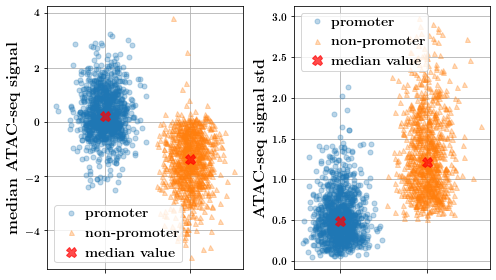

Mann-Whitney U-test
Difference in signal medians of peak sets, p-value: 4.472e-230
Difference in signal stds    of peak sets, p-value: 1.982e-244


In [15]:
atac_days_poslin = ['D0', 'D1', 'D2', 'D3', 'D5_GFPplus']
atac_days_neglin = ['D0', 'D1', 'D2', 'D3', 'D5_GFPminus']
days_pts = [0,1,2,3,5]

bool_EF_peaks = bool_ef_up_peak_selection | bool_ef_down_peak_selection
bool_EFup_promoters   = (atac_df['context']=='promoter') & (atac_df['nearest_gene_id'].isin(ef_up_genes)) & atac_df['tad-id-bonev'].isin(ef_up_tad_numbers)
bool_EFdown_promoters = (atac_df['context']=='promoter') & (atac_df['nearest_gene_id'].isin(ef_down_genes)) & atac_df['tad-id-bonev'].isin(ef_down_tad_numbers)
bool_EF_promoter    = bool_EF_peaks & (bool_EFup_promoters | bool_EFdown_promoters )
bool_EF_nonpromoter = bool_EF_peaks & bool_nonpromoter
print(bool_EF_promoter.sum(), bool_EF_nonpromoter.sum())
bool_EF_dynamic_nonpromoter = bool_EF_peaks & bool_nonpromoter & (bool_down_peaks_35p | bool_up_peaks_35p)

atac_ef_promoter_vals    = atac_df[atac_days_poslin][bool_EF_promoter].values
atac_ef_nonpromoter_vals = atac_df[atac_days_poslin][bool_EF_dynamic_nonpromoter].values
atac_ef_promoter_median_vals = np.median(atac_ef_promoter_vals,axis=1)
atac_ef_promoter_std_vals    = np.std(atac_ef_promoter_vals,axis=1)
atac_ef_nonpromoter_median_vals = np.median(atac_ef_nonpromoter_vals, axis=1)
atac_ef_nonpromoter_std_vals    = np.std(atac_ef_nonpromoter_vals, axis=1)
print(atac_ef_promoter_vals.shape, atac_ef_promoter_median_vals.shape)

fig, axs = plt.subplots(1,2,figsize=(7,4))
axs = axs.ravel()

xpts = np.random.normal(0,0.15,size=len(atac_ef_promoter_median_vals))
axs[0].plot(xpts, atac_ef_promoter_median_vals,
        'o',markersize=5,alpha=0.3,label=r'\bf promoter')
axs[0].plot([0], np.median(atac_ef_promoter_median_vals),
        'X',markersize=10,color='Red',alpha=0.7)

xpts = np.random.normal(1,0.15,size=len(atac_ef_nonpromoter_median_vals))
axs[0].plot(xpts, atac_ef_nonpromoter_median_vals,
        '^',markersize=5,alpha=0.3,label=r'\bf non-promoter')
axs[0].plot([1], np.median(atac_ef_nonpromoter_median_vals),
        'X',markersize=10,color='Red',alpha=0.7,label=r'\bf median value')

axs[0].grid()
axs[0].legend(fontsize=14,loc='lower left',handletextpad=0.0,borderpad=0.2)

##

xpts = np.random.normal(0,0.15,size=len(atac_ef_promoter_std_vals))
axs[1].plot(xpts, atac_ef_promoter_std_vals,
        'o',markersize=5,alpha=0.3,label=r'\bf promoter')
axs[1].plot([0], np.median(atac_ef_promoter_std_vals),
        'X',markersize=10,color='Red',alpha=0.7)

xpts = np.random.normal(1,0.15,size=len(atac_ef_nonpromoter_std_vals))
axs[1].plot(xpts, atac_ef_nonpromoter_std_vals,
        '^',markersize=5,alpha=0.3,label=r'\bf non-promoter')
axs[1].plot([1], np.median(atac_ef_nonpromoter_std_vals),
        'X',markersize=10,color='Red',alpha=0.7,label=r'\bf median value')

axs[1].grid()
axs[1].legend(fontsize=14,loc='upper left',handletextpad=0.0,borderpad=0.2)

axs[0].set_ylabel(r'\bf median ATAC-seq signal',fontsize=16)
axs[1].set_ylabel(r'\bf  ATAC-seq signal std',fontsize=16)
axs[0].set_xticks([0,1])
axs[1].set_xticks([0,1])
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])

plt.tight_layout()
plt.show()

uval_medians, pval_medians = mannwhitneyu(atac_ef_promoter_median_vals, 
                                          atac_ef_nonpromoter_median_vals, 
                                          alternative='two-sided')
uval_std, pval_std = mannwhitneyu(atac_ef_promoter_std_vals, 
                                  atac_ef_nonpromoter_std_vals, 
                                  alternative='two-sided')
print('Mann-Whitney U-test')
print('Difference in signal medians of peak sets, p-value:',f'{pval_medians:.3e}')
print('Difference in signal stds    of peak sets, p-value:',f'{pval_std:.3e}')

(105, 5) (41806, 5)


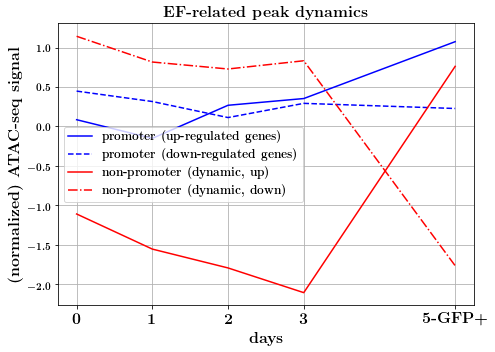

In [16]:
atac_days_poslin = ['D0', 'D1', 'D2', 'D3', 'D5_GFPplus']
atac_days_neglin = ['D0', 'D1', 'D2', 'D3', 'D5_GFPminus']
days_labels = [r'\bf 0', r'\bf 1', r'\bf 2', r'\bf 3', r'\bf 5-GFP+']
days_pts = [0,1,2,3,5]

bool_dynamic_up_peaks      = bool_up_peaks_35p
bool_dynamic_ef_down_peaks = bool_down_peaks_35p

bool_promoter    = (atac_df['context'] == 'promoter')
bool_nonpromoter = (atac_df['context'] != 'promoter')
bool_EF_peaks = bool_ef_up_peak_selection | bool_ef_down_peak_selection
bool_EFup_promoters   = (atac_df['context']=='promoter') & (atac_df['nearest_gene_id'].isin(ef_up_genes)) & atac_df['tad-id-bonev'].isin(ef_up_tad_numbers)
bool_EFdown_promoters = (atac_df['context']=='promoter') & (atac_df['nearest_gene_id'].isin(ef_down_genes)) & atac_df['tad-id-bonev'].isin(ef_down_tad_numbers)
bool_EF_promoter    = bool_EF_peaks & bool_promoter
bool_EF_nonpromoter = bool_EF_peaks & bool_nonpromoter
bool_dynup_EF_nonpromoter   = bool_EF_peaks & bool_nonpromoter & bool_up_peaks_35p
bool_dyndown_EF_nonpromoter = bool_EF_peaks & bool_nonpromoter & bool_down_peaks_35p

## promoter atac values ## 
atac_efup_promoter_vals   = atac_df[atac_days_poslin][bool_EFup_promoters].values
atac_efup_promoter_vals_median   = np.median(atac_efup_promoter_vals,axis=0)
#
atac_efdown_promoter_vals   = atac_df[atac_days_poslin][bool_EFdown_promoters].values
atac_efdown_promoter_vals_median   = np.median(atac_efdown_promoter_vals,axis=0)

## non-promoter atac values ## 
atac_ef_nonpromoter_vals   = atac_df[atac_days_poslin][bool_EF_nonpromoter].values
atac_ef_nonpromoter_vals_median   = np.median(atac_ef_nonpromoter_vals,axis=0)
#
atac_dynup_ef_nonpromoter_vals   = atac_df[atac_days_poslin][bool_dynup_EF_nonpromoter].values
atac_dynup_ef_nonpromoter_vals_median   = np.median(atac_dynup_ef_nonpromoter_vals,axis=0)
#
atac_dyndown_ef_nonpromoter_vals   = atac_df[atac_days_poslin][bool_dyndown_EF_nonpromoter].values
atac_dyndown_ef_nonpromoter_vals_median   = np.median(atac_dyndown_ef_nonpromoter_vals,axis=0)
print(atac_efup_promoter_vals.shape, atac_ef_nonpromoter_vals.shape)


## --------- ##
## make plot ##
## --------- ##
plt.figure(figsize=(7,5))
plt.plot(days_pts, atac_efup_promoter_vals_median,  color='Blue',label=r'\bf promoter (up-regulated genes)')
plt.plot(days_pts, atac_efdown_promoter_vals_median,color='Blue', ls='--',label=r'\bf promoter (down-regulated genes)')

plt.plot(days_pts, atac_dynup_ef_nonpromoter_vals_median,color='Red',label=r'\bf non-promoter (dynamic, up)')
plt.plot(days_pts, atac_dyndown_ef_nonpromoter_vals_median,color='Red',ls='-.',label=r'\bf non-promoter (dynamic, down)')

#plt.ylim(0,)
plt.legend(fontsize=12,loc='center left')
plt.grid()
#plt.title(r'\bf chromatin peak dynamics in EF TADs',fontsize=14)
plt.xlabel(r'\bf days',fontsize=16)
plt.ylabel(r'\bf (normalized) ATAC-seq signal',fontsize=16)

plt.xticks([0,1,2,3,5],days_labels,fontsize=16)
plt.title(r'\bf EF-related peak dynamics',fontsize=16)

plt.tight_layout()
#file_str = '03_EF-TAD-atac-peaks-signal-median-trajectories.pdf'
#plt.savefig('./figures_paper/'+file_str)
plt.show()

## Calculate motif enrichment

In [17]:
# load fimo data
tmp_features = pd.read_csv(data_dir+'/'+fimo_file, sep='\t')

tmp_features = tmp_features.drop(columns=['q-value','matched_sequence'])
tmp_features = tmp_features.rename(columns={'motif_alt_id':'motif_name'})
tmp_features = tmp_features[:-3]

peaks = []
for name in list(tmp_features['sequence_name'].values):
    peaks.append(int(name.split('-')[-1]))
    
tmp_features['peak-number'] = peaks
tmp_features['motif_width'] = tmp_features['stop'] - tmp_features['start']

## place threshold on motif-occurence ##
motif_pval_thr = 1e-4
tmp_features = tmp_features[tmp_features['p-value']<motif_pval_thr]


nmotifs = len(set(tmp_features['motif_name']))
npeaks = 361867 # total number of peaks in dataset (we remove exons from this later)

# -- generate score dataframe -- #
# group rows by peak number, and where multiple instances of a motif appear
# in peak, take max score
tmp_features2 = tmp_features.groupby(['peak-number','motif_name']).agg({'score': ['max']})
tmp_features2.columns = ['score']
tmp_features2 = tmp_features2.reset_index()

# here we unpack dataframe to a df resembling the feature matrix (peaks x motifs) we want
tmp_score_df = tmp_features2[:].pivot_table(index='peak-number',columns='motif_name',fill_value=0.)
tmp_score_df = tmp_score_df.reset_index()
tmp_score_df = tmp_score_df.rename(columns={"Index":'peak-number'})
tmp_score_df.columns = tmp_score_df.columns.droplevel()
tmp_score_df = tmp_score_df.rename(columns={'':'peak-number'})

# here we fill in the missing rows (peaks where no motifs were found)
score_df =  pd.DataFrame(np.arange(1,npeaks+1)).rename(columns={0:'peak-number'})
score_df = pd.merge(score_df,tmp_score_df,on=['peak-number'],how='left')
score_df = score_df.fillna(0)

del tmp_features2
del tmp_score_df

# remove peaks overlapping exons
score_df = score_df[:][bool_exon]
print(score_df.shape)

(333960, 551)


In [18]:
###################################################################
### generate list of motifs in motif database and are expressed ###
###################################################################

rna_thr = 50 ## DEseq2 RNAseq normalization

motif_names = list(score_df.columns[1:])
motif_names_format = [motif.split('_')[0].capitalize() for motif in motif_names]
motif_names_format = [motif.split('(')[0] for motif in motif_names_format]

motif_w_rna_signal = rna_df['ext_gene'][rna_df['ext_gene'].isin(motif_names_format)].tolist()
motif_w_rna_signal = list(set(motif_w_rna_signal))
rna_days_test = ['day1','day2','day3','day4-gfppos','day5-gfppos']

jasper_names = list(score_df.columns[1:])
expressed_motifs = []
expressed_motifs_names = []
for motif in motif_w_rna_signal:
    
    tmp_rna_max_signal = rna_df[rna_days_test][rna_df['ext_gene'] == motif].values.max()
    
    if tmp_rna_max_signal > rna_thr:
        
        tmp_list = list(np.array(jasper_names)[np.where(np.array(motif_names_format)==motif)[0]])
        #print(tmp_list)
        expressed_motifs.append(tmp_list) ## there can be > 1 motif per TF
        expressed_motifs_names.append([motif]*len(tmp_list))

expressed_motifs = [item for sublist in expressed_motifs for item in sublist]
expressed_motifs_names = [item for sublist in expressed_motifs_names for item in sublist]


motif_w_rna_signal = rna_df['ext_gene'][rna_df['ext_gene'].isin(motif_names_format)].tolist()
rna_days_test = ['day1','day2','day3','day4-gfppos','day5-gfppos']

#expressed_motifs = [item for sublist in expressed_motifs for item in sublist]
expressed_motifs.append('Pou5f1::Sox2')
expressed_motifs_names.append('Pou5f1::Sox2')
expressed_motifs.append('FOS::JUN')
expressed_motifs_names.append('Fos::Jun')
expressed_motifs.append('Hand1::Tcf3')
expressed_motifs_names.append('Hand1::Tcf3')
expressed_motifs.append('Bach1::Mafk')
expressed_motifs_names.append('Bach1::Mafk')
expressed_motifs.append('Smad2::Smad3')
expressed_motifs_names.append('Smad2::Smad3')
expressed_motifs.append('Zic1::Zic2')
expressed_motifs_names.append('Zic1::Zic2')

print(expressed_motifs[:10])
print(expressed_motifs_names[:10])

#expressed_motifs = list(set(expressed_motifs))
#expressed_motifs_names = list(set(expressed_motifs_names))

#expressed_motifs.remove('Alx1_1') # remove duplicate

print(len(expressed_motifs), len(expressed_motifs_names))

['Srf_1', 'Srf_2', 'Meis2', 'Zfp128_1', 'Zfp128_2', 'Irx3_1', 'Irx3_2', 'Foxl2', 'Cux1_1', 'Cux1_2']
['Srf', 'Srf', 'Meis2', 'Zfp128', 'Zfp128', 'Irx3', 'Irx3', 'Foxl2', 'Cux1', 'Cux1']
334 334


### helper functions

In [19]:
def compute_pvals_motifs(score_df,bool_signal,bool_bg,verbose=False):
    
    score_df_signal = score_df[bool_signal]
    score_df_bg = score_df[bool_bg]

    if verbose:
        print(bool_signal.sum(), bool_bg.sum())

    log_pvals = []
    for gene_name in list(score_df.columns)[1:]:
        # pick out peaks containing a motif of interest
        bool_motif_signal = (score_df_signal[:][gene_name] > 0)
        bool_motif_bg  = (score_df_bg[:][gene_name] > 0)

        # prepare to pass to hypergeom
        npeaks_signal = bool_signal.sum()
        npeaks = npeaks_signal + bool_bg.sum()
        npeaks_motifs_signal = bool_motif_signal.sum() 
        npeaks_motifs = npeaks_motifs_signal + bool_motif_bg.sum()

        log_pvals.append( hypergeom.logsf(npeaks_motifs_signal-1,npeaks,npeaks_motifs,npeaks_signal) )
    
    return np.array(log_pvals)

### Motif enrichment for dynamic peaks

In [20]:
ef_up_tads = list(set(rna_df['tad-id-bonev'][rna_df['EF-up']]))
ef_down_tads = list(set(rna_df['tad-id-bonev'][rna_df['EF-down']]))
ef_down_tads =  [tad for tad in ef_down_tads if tad not in ef_up_tads]
hk_tads = list(set(rna_df['tad-id-bonev'][rna_df['HK']]))

hk_tads         = [tad for tad in hk_tads if tad not in ef_up_tads]
hk_tads         = [tad for tad in hk_tads if tad not in ef_down_tads]
# hk_tads.remove(-1)
#print(sorted(hk_tads))

bool_atac_hk_tad      = atac_df['tad-id-bonev'].isin(hk_tads)
bool_atac_efup_tad    = atac_df['tad-id-bonev'].isin(ef_up_tads)
bool_atac_efdown_tad  = atac_df['tad-id-bonev'].isin(ef_down_tads)
print(bool_atac_efup_tad.sum(), bool_atac_efdown_tad.sum(), bool_atac_hk_tad.sum())

8016 47060 13218


In [21]:
score_df_keep_cols = ['peak-number'] + expressed_motifs # create new list of columns with expressed motifs

bool_dyn_up_signal   = bool_nonpromoter & bool_up_peaks_35p
bool_dyn_down_signal = bool_nonpromoter & bool_down_peaks_35p
bool_bg     = bool_atac_hk_tad
print(bool_dyn_up_signal.sum(),bool_dyn_down_signal.sum(), bool_bg.sum())

pvals_dyn_up   = compute_pvals_motifs(score_df[score_df_keep_cols],bool_dyn_up_signal,bool_bg,verbose=False)
pvals_dyn_down = compute_pvals_motifs(score_df[score_df_keep_cols],bool_dyn_down_signal,bool_bg,verbose=False)

sort_idx = np.argsort(pvals_dyn_up)
motif_names_arr = score_df[score_df_keep_cols].columns[1:]
print(len(sort_idx), len(motif_names_arr))

7529 48 13218
334 334


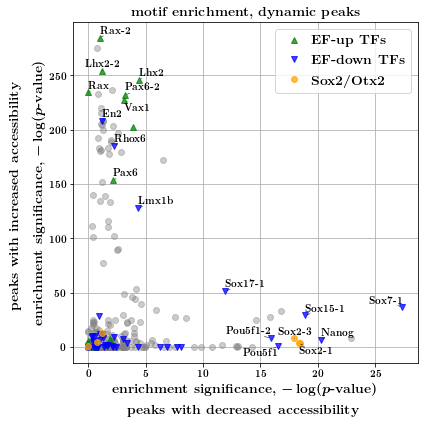

In [22]:
plt.figure(figsize=(6,6))

efup_genes_plt   = ['Rax','Rax_2','Pax6','Pax6_2','Lhx2','Lhx2_2','Vax1']
efup_genes_idx   = [list(motif_names_arr).index(gene) for gene in efup_genes_plt]
efdown_genes_plt = ['Rhox6', 'Lmx1b', 'En2', 'Pou5f1_2', 'Sox7_1', 'Sox15_1', 'Nanog', 'Sox17_1', 'Pou5f1']
efdown_genes_idx = [list(motif_names_arr).index(gene) for gene in efdown_genes_plt]
ef_related_genes_plt = ['Sox2_1','Sox2_3']
ef_related_genes_idx = [list(motif_names_arr).index(gene) for gene in ef_related_genes_plt]

motif_gene_names_arr = np.array([motif.split('_')[0].split('(')[0].capitalize() for motif in motif_names_arr])
bool_efup_tfs   = np.in1d(motif_gene_names_arr,ef_up_genes)
bool_efdown_tfs = np.in1d(motif_gene_names_arr,ef_down_genes)
bool_ef_related_tfs = np.in1d(motif_gene_names_arr,['Sox2','Otx2'])
bool_other = (~bool_efup_tfs) & (~bool_efdown_tfs) & (~bool_ef_related_tfs)

plt.plot(-pvals_dyn_down[bool_other], -pvals_dyn_up[bool_other], 'o',color='Gray',alpha=0.4)
plt.plot(-pvals_dyn_down[bool_efup_tfs], -pvals_dyn_up[bool_efup_tfs], 
         '^',markersize=6,color='Green',alpha=0.75,label=r'\bf EF-up TFs')
plt.plot(-pvals_dyn_down[bool_efdown_tfs], -pvals_dyn_up[bool_efdown_tfs], 
         'v',markersize=6,color='Blue',alpha=0.75,label=r'\bf EF-down TFs')
plt.plot(-pvals_dyn_down[bool_ef_related_tfs], -pvals_dyn_up[bool_ef_related_tfs], 
         'o',markersize=6,color='Orange',alpha=0.75,label=r'\bf Sox2/Otx2')

ax = plt.gca()

texts1 = []
for k, gene in enumerate(efup_genes_plt):
    texts1.append(ax.text(-pvals_dyn_down[efup_genes_idx[k]], -pvals_dyn_up[efup_genes_idx[k]],
                          r'\bf '+gene.replace('_','-'), fontsize=10))
    
for k, gene in enumerate(efdown_genes_plt):
    texts1.append(ax.text(-pvals_dyn_down[efdown_genes_idx[k]], -pvals_dyn_up[efdown_genes_idx[k]],
                          r'\bf '+gene.replace('_','-'), fontsize=10))
    
for k, gene in enumerate(ef_related_genes_plt):
    texts1.append(ax.text(-pvals_dyn_down[ef_related_genes_idx[k]], -pvals_dyn_up[ef_related_genes_idx[k]],
                          r'\bf '+gene.replace('_','-'), fontsize=10))
    
adjust_text(texts1, only_move={'points':'y', 'texts':'xy'},
            precision=0.05,
            expand_text=(1.1, 1.0), 
            expand_points=(1.51, 1.55), 
            force_text=(1.4, 2.85),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5), ax=ax) # adjust labels

ylab_str = r'\bf peaks with increased accessibility \\[10pt] enrichment significance, $-\log(p\text{-value})$'
xlab_str = r'\bf enrichment significance, $-\log(p\text{-value})$ \\[7pt] \phantom{xxx} peaks with decreased accessibility'
plt.ylabel(ylab_str,fontsize=14)
plt.xlabel(xlab_str,fontsize=14)
plt.title(r'\bf motif enrichment, dynamic peaks',fontsize=14)
plt.legend(fontsize=14, handletextpad=0.2)

plt.grid()
plt.tight_layout()
#file_str = '03_atac-peaks-dynamic-peaks-motif-enrichment.pdf'
#plt.savefig('./figures_paper/'+file_str)
plt.show()

## TF-motif accessibility-expression correlation analysis

In [23]:
def compute_rna_motif_correlation_distributions(score_df,
                                                atac_df,
                                                rna_df,
                                                rna_days, atac_days,
                                                expressed_motifs,
                                                expressed_motifs_names,
                                                bool_signal_peak_selection,
                                                bool_bg_peak_selection,
                                                motif_select):
    
    
    #motif_select = expressed_motifs[motif_idx]
    motif_idx = expressed_motifs.index(motif_select)
    if motif_select == 'Pou5f1::Sox2':
        tf_select = 'Pou5f1'
    elif motif_select == 'Hand1::Tcf3':
        tf_select = 'Hand1'
    elif motif_select == 'Bach1::Mafk':
        tf_select = 'Bach1'
    elif motif_select == 'Smad2::Smad3':
        tf_select = 'Smad2'  
    elif motif_select.startswith('Pax6Sox2'):
        tf_select = 'Pax6'
    elif motif_select == 'FOS::JUN':
        print('No expression data for this motif', motif_select)
        return [], []
    else:
        tf_select    = expressed_motifs_names[motif_idx]

    tmp_motif_peak_scores = score_df[motif_select].values.astype(int)

    bool_motif_present = (tmp_motif_peak_scores > 0) 
    #print('# genome-wide instances:', bool_motif_present.sum())

    bool_context = (atac_df['context'] != 'promoter') #| (atac_df['context'] == 'promoter')
    bool_motif_signal_peaks = bool_motif_present & bool_signal_peak_selection & bool_context
    bool_motif_bg_peaks     = (~bool_motif_present) & bool_bg_peak_selection & bool_context

    tmp_signal_atac_vals = atac_df[atac_days][bool_motif_signal_peaks].values
    tmp_bg_atac_vals     = atac_df[atac_days][bool_motif_bg_peaks].values
    ##############################

    tmp_motif_expr = rna_df[rna_days][rna_df['ext_gene'] == tf_select].iloc[0].values.flatten()
    
    motif_signal_correlations = []
    motif_bg_correlations     = []

    for k in range(bool_motif_signal_peaks.sum()):    
        tmp_corr = pearsonr(tmp_signal_atac_vals[k],tmp_motif_expr)[0]
        if not np.isnan(tmp_corr):
            motif_signal_correlations.append(tmp_corr)

    for k in range(bool_motif_bg_peaks.sum()):    
        tmp_corr = pearsonr(tmp_bg_atac_vals[k],tmp_motif_expr)[0]
        if not np.isnan(tmp_corr):
            motif_bg_correlations.append(tmp_corr)
                
    return np.array(motif_signal_correlations), np.array(motif_bg_correlations)


def compute_rna_motif_pos_neg_correlations(score_df,
                                           atac_df,
                                           rna_df,
                                           rna_days, atac_days,
                                           expressed_motifs,
                                           expressed_motifs_names,
                                           bool_signal_peak_selection,
                                           bool_bg_peak_selection):
    
    tf_name = []
    tf_correlations = []
    tf_pvals = []
    tf_pos_correlations = []
    tf_pos_pvals = []
    tf_neg_correlations = []
    tf_neg_pvals = []
    
    for k, motif_select in enumerate(expressed_motifs[:-5]):
        
        if (k % 50) == 0:
            print(k,'of',len(expressed_motifs[:-5]))

        motif_signal_correlations, motif_bg_correlations = \
                        compute_rna_motif_correlation_distributions(score_df,
                                                                    atac_df,
                                                                    rna_df,
                                                                    rna_days, atac_days,
                                                                    expressed_motifs,
                                                                    expressed_motifs_names,
                                                                    bool_signal_peak_selection,
                                                                    bool_bg_peak_selection,
                                                                    motif_select)
        
        if len(motif_signal_correlations) == 0:
            continue
        
        signal_positive_corrs = motif_signal_correlations[motif_signal_correlations>0]
        signal_negative_corrs = motif_signal_correlations[motif_signal_correlations<0]
        bg_positive_corrs = motif_bg_correlations[motif_bg_correlations>0]
        bg_negative_corrs = motif_bg_correlations[motif_bg_correlations<0]

        mwu_test, mwu_pval = mannwhitneyu(motif_signal_correlations, 
                                  motif_bg_correlations, 
                                  alternative='two-sided')
        mwu_test_pos, mwu_pval_pos = mannwhitneyu(signal_positive_corrs, bg_positive_corrs, 
                                                  alternative='greater')
        mwu_test_neg, mwu_pval_neg = mannwhitneyu(signal_negative_corrs, bg_negative_corrs, 
                                                  alternative='less')
        
        
        tf_name.append(motif_select)
        tf_correlations.append(np.median(motif_signal_correlations))
        tf_pvals.append(mwu_pval)
        tf_pos_correlations.append(np.median(signal_positive_corrs))
        tf_pos_pvals.append(mwu_pval_pos)
        tf_neg_correlations.append(np.median(signal_negative_corrs))
        tf_neg_pvals.append(mwu_pval_neg)
        
    tf_correlations = np.array(tf_correlations)
    tf_pvals = np.array(tf_pvals)
    tf_pos_correlations = np.array(tf_pos_correlations)
    tf_pos_pvals = np.array(tf_pos_pvals)
    tf_neg_correlations = np.array(tf_neg_correlations)
    tf_neg_pvals = np.array(tf_neg_pvals)
    
    print('DONE!')
    
    return tf_name, tf_correlations, tf_pvals, \
           tf_pos_correlations, tf_pos_pvals, \
           tf_neg_correlations, tf_neg_pvals

In [24]:
## up-regulated gene clusters ##
tmp_bool_clust = rna_df['cluster-0']
ef_up_clust_tad_numbers = sorted(list(set(rna_df['tad-id-bonev'][tmp_bool_clust])))
ef_up_clust_tad_numbers = list(filter(lambda a: a != -1, ef_up_clust_tad_numbers))
print('# up-regulated gene tads:',len(ef_up_clust_tad_numbers))

## down-regulated gene clusters ##
tmp_bool_clust = rna_df['cluster-2'] | rna_df['cluster-3'] | rna_df['cluster-5']
ef_down_clust_tad_numbers = sorted(list(set(rna_df['tad-id-bonev'][tmp_bool_clust])))
ef_down_clust_tad_numbers = list(filter(lambda a: a != -1, ef_down_clust_tad_numbers))
print('# down-regulated gene tads:',len(ef_down_clust_tad_numbers))
ef_down_clust_tad_numbers = [tad for tad in ef_down_clust_tad_numbers if tad not in ef_up_clust_tad_numbers]
print('# down-regulated gene tads:',len(ef_down_clust_tad_numbers), '(after removing overlap with up)')

## transient gene clusters ##
tmp_bool_clust = rna_df['cluster-1'] | rna_df['cluster-4']
ef_trans_clust_tad_numbers = sorted(list(set(rna_df['tad-id-bonev'][tmp_bool_clust])))
ef_trans_clust_tad_numbers = list(filter(lambda a: a != -1, ef_trans_clust_tad_numbers))
print('# transient gene tads:',len(ef_trans_clust_tad_numbers))
ef_trans_clust_tad_numbers = [tad for tad in ef_trans_clust_tad_numbers if 
                              ((tad not in ef_up_clust_tad_numbers) & (tad not in ef_down_clust_tad_numbers))]
print('# transient gene tads:',len(ef_trans_clust_tad_numbers), '(after removing overlap with up & down)')
print()

## background (HK) gene clusters ##
hk_tad_numbers = sorted(list(set( rna_df['tad-id-bonev'][rna_df['HK']] )))
hk_tad_numbers = list(filter(lambda a: a != -1, hk_tad_numbers))
hk_tad_numbers = [tad for tad in hk_tad_numbers if tad not in ef_up_clust_tad_numbers]
hk_tad_numbers = [tad for tad in hk_tad_numbers if tad not in ef_down_clust_tad_numbers]
hk_tad_numbers = [tad for tad in hk_tad_numbers if tad not in ef_trans_clust_tad_numbers]


## boolean vectors for selecting peaks ## 
bool_atac_peak_ef_up_clust = atac_df['tad-id-bonev'].isin(ef_up_clust_tad_numbers)
print('# up peaks:',bool_atac_peak_ef_up_clust.sum())
bool_atac_peak_ef_down_clust = atac_df['tad-id-bonev'].isin(ef_down_clust_tad_numbers)
print('# down peaks:',bool_atac_peak_ef_down_clust.sum())
bool_atac_peak_ef_trans_clust = atac_df['tad-id-bonev'].isin(ef_trans_clust_tad_numbers)
print('# trans peaks:',bool_atac_peak_ef_trans_clust.sum())
bool_hk_peak_selection = atac_df['tad-id-bonev'].isin(hk_tad_numbers)
print('# bg peaks:',bool_hk_peak_selection.sum())

# up-regulated gene tads: 28
# down-regulated gene tads: 242
# down-regulated gene tads: 237 (after removing overlap with up)
# transient gene tads: 109
# transient gene tads: 84 (after removing overlap with up & down)

# up peaks: 4339
# down peaks: 35089
# trans peaks: 11971
# bg peaks: 13218


In [25]:
rna_days  = ['day1','day2','day3','day5-gfppos','day5-gfpneg']
atac_days = ['D1', 'D2', 'D3', 'D5_GFPplus', 'D5_GFPminus']

tf_name, tf_efup_clust_corr, tf_efup_clust_pvals, \
     tf_efup_clust_pos_corr, tf_efup_clust_pos_pvals, \
     tf_efup_clust_neg_corr, tf_efup_clust_neg_pvals = \
        compute_rna_motif_pos_neg_correlations(score_df,
                                               atac_df,
                                               rna_df,
                                               rna_days, atac_days,
                                               expressed_motifs,
                                               expressed_motifs_names,
                                               bool_atac_peak_ef_up_clust,
                                               bool_hk_peak_selection)

tf_name, tf_efdown_clust_corr, tf_efdown_clust_pvals, \
     tf_efdown_clust_pos_corr, tf_efdown_clust_pos_pvals, \
     tf_efdown_clust_neg_corr, tf_efdown_clust_neg_pvals = \
        compute_rna_motif_pos_neg_correlations(score_df,
                                               atac_df,
                                               rna_df,
                                               rna_days, atac_days,
                                               expressed_motifs,
                                               expressed_motifs_names,
                                               bool_atac_peak_ef_down_clust,
                                               bool_hk_peak_selection)

0 of 329
50 of 329
100 of 329
150 of 329
200 of 329
250 of 329
300 of 329
DONE!
0 of 329
50 of 329
100 of 329
150 of 329
200 of 329
250 of 329
300 of 329
DONE!


In [26]:
plt_tfs = [tf.split('_')[0].split('(')[0].capitalize() for tf in tf_name]

bool_efup_clust = np.in1d(np.array(plt_tfs),ef_up_tfs)
bool_efdown_clust = np.in1d(np.array(plt_tfs),ef_down_tfs)
bool_ef_related_clust = np.in1d(np.array(plt_tfs),['Sox2','Otx2'])

efup_genes_plt = ['Rax','Rax_2','Pax6','Pax6_2','Lhx2','Lhx2_2','Six3']
efup_genes_idx = [tf_name.index(gene) for gene in efup_genes_plt]

efdown_genes_plt = ['Pou5f1_2', 'Nanog']
efdown_genes_idx = [tf_name.index(gene) for gene in efdown_genes_plt]

ef_related_genes_plt = ['Sox2_1','Sox2_3', 'Otx2']
ef_related_genes_idx = [tf_name.index(gene) for gene in ef_related_genes_plt]

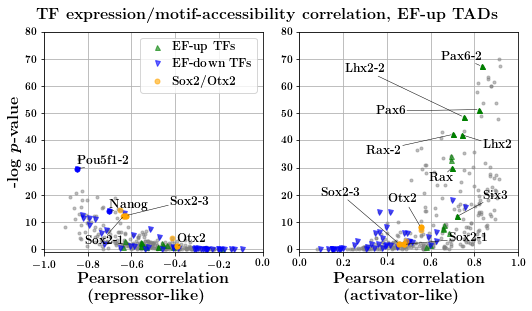

In [27]:
#####################
## EF up TAd peaks ##
#####################

peak_set = 'efup_clust'
pos_corrs = tf_efup_clust_pos_corr
pos_pvals = tf_efup_clust_pos_pvals
neg_corrs = tf_efup_clust_neg_corr
neg_pvals = tf_efup_clust_neg_pvals
#
pos_pvals = -np.log(pos_pvals)
neg_pvals = -np.log(neg_pvals)

## highlight some interesting TFs ##

plt_tfs = [tf.split('_')[0].split('(')[0].capitalize() for tf in tf_name]

bool_efup_clust = np.in1d(np.array(plt_tfs),ef_up_tfs)
bool_efdown_clust = np.in1d(np.array(plt_tfs),ef_down_tfs)
bool_ef_related_clust = np.in1d(np.array(plt_tfs),['Sox2','Otx2'])

efup_genes_plt = ['Rax','Rax_2','Pax6','Pax6_2','Lhx2','Lhx2_2','Six3']
efup_genes_idx = [tf_name.index(gene) for gene in efup_genes_plt]
efdown_genes_plt = ['Pou5f1_2', 'Nanog']
efdown_genes_idx = [tf_name.index(gene) for gene in efdown_genes_plt]
ef_related_genes_plt = ['Sox2_1','Sox2_3', 'Otx2']
ef_related_genes_idx = [tf_name.index(gene) for gene in ef_related_genes_plt]


###############
## make plot ##
###############


fig, axs = plt.subplots(1,2,figsize=(7.5,4.5))
axs = axs.ravel()


axs[1].plot(pos_corrs,pos_pvals,'o',markersize=3,color='Gray',alpha=0.5)
axs[1].plot(pos_corrs[bool_efup_clust],pos_pvals[bool_efup_clust],
            '^',markersize=5,color='Green',alpha=0.6)
axs[1].plot(pos_corrs[bool_efdown_clust],pos_pvals[bool_efdown_clust],
            'v',markersize=5,color='Blue',alpha=0.6)
axs[1].plot(pos_corrs[bool_ef_related_clust],pos_pvals[bool_ef_related_clust],
            'o',markersize=5,color='Orange',alpha=0.6)
#
axs[0].plot(neg_corrs,neg_pvals,'o',markersize=3,color='Gray',alpha=0.5)
axs[0].plot(neg_corrs[bool_efup_clust],neg_pvals[bool_efup_clust],
            '^',markersize=5,color='Green',alpha=0.6,label=r'\bf EF-up TFs')
axs[0].plot(neg_corrs[bool_efdown_clust],neg_pvals[bool_efdown_clust],
            'v',markersize=5,color='Blue',alpha=0.6,label=r'\bf EF-down TFs')
axs[0].plot(neg_corrs[bool_ef_related_clust],neg_pvals[bool_ef_related_clust],
            'o',markersize=5,color='Orange',alpha=0.6,label=r'\bf Sox2/Otx2')

###
texts1 = []
for k, gene in enumerate(efup_genes_plt):
    bool_pass = True
    if bool_pass:
        axs[1].plot(pos_corrs[efup_genes_idx[k]],pos_pvals[efup_genes_idx[k]],'^',markersize=5,color='Green')
        texts1.append(axs[1].text(pos_corrs[efup_genes_idx[k]],
                                  pos_pvals[efup_genes_idx[k]],
                                  r'\bf '+gene.replace('_','-'),
                                  fontsize=12))

###
texts2 = []
for k, gene in enumerate(efdown_genes_plt):
    bool_pass = True
    if bool_pass:
        axs[0].plot(neg_corrs[efdown_genes_idx[k]],neg_pvals[efdown_genes_idx[k]],'o',markersize=5,color='Blue')
        texts2.append(axs[0].text(neg_corrs[efdown_genes_idx[k]],
                                  neg_pvals[efdown_genes_idx[k]],
                                  r'\bf '+gene.replace('_','-'),
                                  fontsize=12))

###
for k, gene in enumerate(ef_related_genes_plt):
    bool_pass = True
    if bool_pass:
        axs[1].plot(pos_corrs[ef_related_genes_idx[k]],pos_pvals[ef_related_genes_idx[k]],
                    'o',markersize=5,color='Orange')
        texts1.append(axs[1].text(pos_corrs[ef_related_genes_idx[k]],
                                  pos_pvals[ef_related_genes_idx[k]],
                                  r'\bf '+gene.replace('_','-'),
                                  fontsize=12))
        #
        axs[0].plot(neg_corrs[ef_related_genes_idx[k]],neg_pvals[ef_related_genes_idx[k]],
                    'o',markersize=5,color='Orange')
        texts2.append(axs[0].text(neg_corrs[ef_related_genes_idx[k]],
                                  neg_pvals[ef_related_genes_idx[k]],
                                  r'\bf '+gene.replace('_','-'),
                                  fontsize=12))
###
adjust_text(texts1, only_move={'points':'y', 'texts':'xy'},
            precision=0.05,
            expand_text=(1.5, 1.2), 
            expand_points=(1.51, 1.55), 
            force_text=(2.4, 2.85),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5), ax=axs[1]) # adjust labels
#
adjust_text(texts2, only_move={'points':'y', 'texts':'xy'},
            precision=0.05,
            expand_text=(1.5, 1.2), 
            expand_points=(1.51, 1.55), 
            force_text=(2.5, 3.85),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5), ax=axs[0]) # adjust labels
####
    
ylow,yupp = [-1,80]
axs[0].set_xlim(-1,0)
axs[1].set_xlim(0,1)
axs[0].set_ylim(ylow,yupp)
axs[1].set_ylim(ylow,yupp)

axs[0].set_ylabel(r'\bf -log $p$-value',fontsize=16)

for i in range(2):
    axs[i].grid()
    axs[i].set_xlabel(r'\bf Pearson correlation',fontsize=16)
axs[0].legend(fontsize=12,handletextpad=0.2)
axs[0].set_xlabel(r'\bf Pearson correlation \\[5pt] \phantom{xx} (repressor-like)',fontsize=16)
axs[1].set_xlabel(r'\bf Pearson correlation \\[5pt] \phantom{xx} (activator-like)',fontsize=16)
    
#axs[0].set_title(r'\bf repressor-like',fontsize=16)
#axs[1].set_title(r'\bf activator-like',fontsize=16)
st = fig.suptitle(r'\bf TF expression/motif-accessibility correlation, EF-up TADs', fontsize=16)
st.set_y(0.95)

plt.tight_layout()
#file_str = '04_motif_expr_access_correlations_pvals-'+peak_set+'.pdf'
#plt.savefig('./figures_paper/'+file_str)
plt.show()

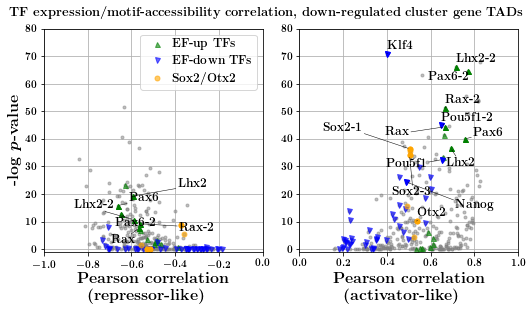

In [28]:
###########################################
## Down-regulated gene cluster TAD peaks ##
###########################################

plt_tfs = [tf.split('_')[0].split('(')[0].capitalize() for tf in tf_name]

bool_efup_clust = np.in1d(np.array(plt_tfs),ef_up_tfs)
bool_efdown_clust = np.in1d(np.array(plt_tfs),ef_down_tfs)
bool_ef_related_clust = np.in1d(np.array(plt_tfs),['Sox2','Otx2'])

efup_genes_plt = ['Rax','Rax_2','Pax6','Pax6_2','Lhx2','Lhx2_2']
efup_genes_idx = [tf_name.index(gene) for gene in efup_genes_plt]

efdown_genes_plt = ['Pou5f1_2', 'Pou5f1', 'Nanog', 'Klf4']
efdown_genes_idx = [tf_name.index(gene) for gene in efdown_genes_plt]

ef_related_genes_plt = ['Sox2_1','Sox2_3', 'Otx2']
ef_related_genes_idx = [tf_name.index(gene) for gene in ef_related_genes_plt]

###############
## make plot ##
###############

#
peak_set = 'efdown_clust'
pos_corrs = tf_efdown_clust_pos_corr
pos_pvals = tf_efdown_clust_pos_pvals
neg_corrs = tf_efdown_clust_neg_corr
neg_pvals = tf_efdown_clust_neg_pvals
#
pos_pvals = -np.log(pos_pvals)
neg_pvals = -np.log(neg_pvals)

fig, axs = plt.subplots(1,2,figsize=(7.5,4.5))
axs = axs.ravel()


axs[1].plot(pos_corrs,pos_pvals,'o',markersize=3,color='Gray',alpha=0.5)
axs[1].plot(pos_corrs[bool_efup_clust],pos_pvals[bool_efup_clust],
            '^',markersize=5,color='Green',alpha=0.6)
axs[1].plot(pos_corrs[bool_efdown_clust],pos_pvals[bool_efdown_clust],
            'v',markersize=5,color='Blue',alpha=0.6)
axs[1].plot(pos_corrs[bool_ef_related_clust],pos_pvals[bool_ef_related_clust],
            'o',markersize=5,color='Orange',alpha=0.6)
#
axs[0].plot(neg_corrs,neg_pvals,'o',markersize=3,color='Gray',alpha=0.5)
axs[0].plot(neg_corrs[bool_efup_clust],neg_pvals[bool_efup_clust],
            '^',markersize=5,color='Green',alpha=0.6,label=r'\bf EF-up TFs')
axs[0].plot(neg_corrs[bool_efdown_clust],neg_pvals[bool_efdown_clust],
            'v',markersize=5,color='Blue',alpha=0.6,label=r'\bf EF-down TFs')
axs[0].plot(neg_corrs[bool_ef_related_clust],neg_pvals[bool_ef_related_clust],
            'o',markersize=5,color='Orange',alpha=0.6,label=r'\bf Sox2/Otx2')

###
texts1 = []
texts2 = []
for k, gene in enumerate(efup_genes_plt):
    bool_pass = True
    if bool_pass:
        axs[1].plot(pos_corrs[efup_genes_idx[k]],pos_pvals[efup_genes_idx[k]],'^',markersize=5,color='Green')
        texts1.append(axs[1].text(pos_corrs[efup_genes_idx[k]],
                                  pos_pvals[efup_genes_idx[k]],
                                  r'\bf '+gene.replace('_','-'),
                                  fontsize=12))
        axs[0].plot(neg_corrs[efup_genes_idx[k]],neg_pvals[efup_genes_idx[k]],'^',markersize=5,color='Green')
        texts2.append(axs[0].text(neg_corrs[efup_genes_idx[k]],
                                  neg_pvals[efup_genes_idx[k]],
                                  r'\bf '+gene.replace('_','-'),
                                  fontsize=12))

###
#
for k, gene in enumerate(efdown_genes_plt):
    bool_pass = True
    if bool_pass:
        axs[1].plot(pos_corrs[efdown_genes_idx[k]],pos_pvals[efdown_genes_idx[k]],'v',markersize=5,color='Blue')
        texts1.append(axs[1].text(pos_corrs[efdown_genes_idx[k]],
                                  pos_pvals[efdown_genes_idx[k]],
                                  r'\bf '+gene.replace('_','-'),
                                  fontsize=12))

###
for k, gene in enumerate(ef_related_genes_plt):
    bool_pass = True
    if bool_pass:
        axs[1].plot(pos_corrs[ef_related_genes_idx[k]],pos_pvals[ef_related_genes_idx[k]],
                    'o',markersize=5,color='Orange')
        texts1.append(axs[1].text(pos_corrs[ef_related_genes_idx[k]],
                                  pos_pvals[ef_related_genes_idx[k]],
                                  r'\bf '+gene.replace('_','-'),
                                  fontsize=12))
        #
        axs[0].plot(neg_corrs[ef_related_genes_idx[k]],neg_pvals[ef_related_genes_idx[k]],
                    'o',markersize=5,color='Orange')
        #texts2.append(axs[0].text(neg_corrs[ef_related_genes_idx[k]],
        #                          neg_pvals[ef_related_genes_idx[k]],
        #                          r'\bf '+gene.replace('_','-'),
        #                          fontsize=12))
###
adjust_text(texts1, only_move={'points':'y', 'texts':'xy'},
            precision=0.05,
            expand_text=(1.25, 1.15), 
            expand_points=(1.25, 1.25), 
            force_text=(1.4, 1.55),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5), ax=axs[1]) # adjust labels
#
adjust_text(texts2, only_move={'points':'y', 'texts':'xy'},
            precision=0.05,
            expand_text=(1.2, 1.5), 
            expand_points=(1.25, 1.25), 
            force_text=(1.2, 1.15),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5), ax=axs[0]) # adjust labels
####
    
ylow,yupp = [-1,80]
axs[0].set_xlim(-1,0)
axs[1].set_xlim(0,1)
axs[0].set_ylim(ylow,yupp)
axs[1].set_ylim(ylow,yupp)

#axs[1].set_yticklabels([])
axs[0].set_ylabel(r'\bf -log $p$-value',fontsize=16)

for i in range(2):
    axs[i].grid()
    #axs[i].set_xlabel(r'\bf Pearson correlation',fontsize=16)
axs[0].legend(fontsize=12,handletextpad=0.2)   
# axs[0].set_title(r'\bf repressor-like',fontsize=16)
# axs[1].set_title(r'\bf activator-like',fontsize=16)
axs[0].set_xlabel(r'\bf Pearson correlation \\[5pt] \phantom{xx} (repressor-like)',fontsize=16)
axs[1].set_xlabel(r'\bf Pearson correlation \\[5pt] \phantom{xx} (activator-like)',fontsize=16)
    
#axs[0].set_title(r'\bf repressor-like',fontsize=16)
#axs[1].set_title(r'\bf activator-like',fontsize=16)
st = fig.suptitle(r'\bf TF expression/motif-accessibility correlation, down-regulated cluster gene TADs', fontsize=13)
st.set_y(0.95)

plt.tight_layout()
#file_str = '04_motif_expr_access_correlations_pvals-'+peak_set+'.pdf'
#plt.savefig('./figures_paper/'+file_str)
plt.show()

## Model peaks with increasing/decreasing signal using logistic regression

In [29]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [30]:
## Use TFs differentially expressed
## 0. build candidate ef regulators
ef_up_down_tfs = list(set(ef_up_tfs + ef_down_tfs + d2d3_up_tfs + d2d3_down_tfs))

candidate_ef_regulators = [motif for motif in expressed_motifs 
                           if motif.split('_')[0].split('(')[0].capitalize() in ef_up_down_tfs]

candidate_ef_regulators.append('Sox2')
candidate_ef_regulators.append('Sox2_1')
candidate_ef_regulators.append('Sox2_2')
candidate_ef_regulators.append('Sox2_3')
candidate_ef_regulators.append('Otx2')
candidate_ef_regulators.append('Otx2_2')

tf_corr_mat = np.corrcoef(score_df[sorted(candidate_ef_regulators)][bool_atac_peak_ef_up_clust].values.T)

# keep only candidate regulators in model ##
linreg_candidate_ef_regulators = candidate_ef_regulators.copy()
linreg_candidate_ef_regulators = sorted(linreg_candidate_ef_regulators)

In [31]:
## 1. construct features for modelling differences ##

bool_context = (atac_df['context'] != 'promoter')

## select peaks ##
bool_efup_clust_peaks = bool_atac_peak_ef_up_clust & bool_context
bool_dynamic_peaks = (bool_up_peaks_35p | bool_down_peaks_35p) #& bool_context

### construct input for modelling ###
datac_ef_peaks_35p   = log2fc_35p[bool_efup_clust_peaks]
datac_dynamic_peaks_35p  = log2fc_35p[bool_dynamic_peaks]

## remove lowly variable peaks ##
log2fc_thr = 1.0
bool_min_fc = (np.abs(datac_ef_peaks_35p)>log2fc_thr).values
datac_ef_peaks_35p = datac_ef_peaks_35p[bool_min_fc]

## EFup peaks -- construct feature matrices (collapsing motif features)
peak_select_features = score_df[linreg_candidate_ef_regulators][bool_efup_clust_peaks]
peak_select_motifs = peak_select_features.columns.values
peak_select_motifs_names = np.array([motif.split('_')[0].split('(')[0].capitalize()
                                     for motif in peak_select_motifs])
peak_collapsed_features = []
collapsed_motif_names = sorted(list(set(peak_select_motifs_names)))
for tf in collapsed_motif_names:
    
    tmp_motif_list = list(peak_select_motifs[peak_select_motifs_names==tf])
    #print(tmp_motif_list)
    peak_collapsed_features.append((peak_select_features[tmp_motif_list].values.sum(axis=1)>0)*1)
    
peak_collapsed_features = np.array(peak_collapsed_features).T
peak_collapsed_features.shape

## keep features for selected peaks
collapsed_feat_mat_ef_peaks  = peak_collapsed_features[bool_min_fc,:]
print(collapsed_feat_mat_ef_peaks.shape)


## dynamic peaks -- construct feature matrices (collapsing motif features)
dyn_peak_select_features = score_df[linreg_candidate_ef_regulators][bool_dynamic_peaks]
dyn_peak_select_motifs = peak_select_features.columns.values
dyn_peak_select_motifs_names = np.array([motif.split('_')[0].split('(')[0].capitalize()
                                     for motif in dyn_peak_select_motifs])
dyn_peak_collapsed_features = []
dyn_collapsed_motif_names = sorted(list(set(dyn_peak_select_motifs_names)))
for tf in collapsed_motif_names:
    
    tmp_motif_list = list(dyn_peak_select_motifs[dyn_peak_select_motifs_names==tf])
    #print(tmp_motif_list)
    dyn_peak_collapsed_features.append((dyn_peak_select_features[tmp_motif_list].values.sum(axis=1)>0)*1)
    
dyn_peak_collapsed_features = np.array(dyn_peak_collapsed_features).T
print(dyn_peak_collapsed_features.shape)

(2337, 43)
(7835, 43)


In [32]:
peak_behaviour_35p     = (datac_ef_peaks_35p > 0) * 1
dyn_peak_behaviour_35p = (datac_dynamic_peaks_35p > 0) * 1
print((datac_ef_peaks_35p > 0).sum(), (datac_ef_peaks_35p < 0).sum())
print((datac_dynamic_peaks_35p > 0).sum(), (datac_dynamic_peaks_35p < 0).sum())

logreg_params = {'random_state':42, 
                 'class_weight':'balanced',
                }

logreg_35p = LogisticRegressionCV(cv=5,**logreg_params).fit(collapsed_feat_mat_ef_peaks, peak_behaviour_35p)
best_C = logreg_35p.C_[0]
logreg_dyn = LogisticRegressionCV(cv=5,**logreg_params).fit(dyn_peak_collapsed_features, dyn_peak_behaviour_35p)
best_C_dyn = logreg_dyn.C_[0]

logreg_35p_coefs = []
logreg_35p_scores = []
logreg_dyn_coefs = []
logreg_dyn_scores = []
for rnd in np.random.randint(0,100000,size=10):
    logreg_35p = LogisticRegression(C=best_C,random_state=rnd).fit(collapsed_feat_mat_ef_peaks, 
                                                                   peak_behaviour_35p)
    logreg_dyn = LogisticRegression(C=best_C,random_state=rnd).fit(dyn_peak_collapsed_features, 
                                                                       dyn_peak_behaviour_35p)
    
    logreg_35p_coefs.append(list(logreg_35p.coef_[0]))
    logreg_35p_scores.append(logreg_35p.score(collapsed_feat_mat_ef_peaks, peak_behaviour_35p))
    logreg_dyn_coefs.append(list(logreg_dyn.coef_[0]))
    logreg_dyn_scores.append(logreg_dyn.score(dyn_peak_collapsed_features,dyn_peak_behaviour_35p))

print(np.mean(logreg_35p_scores))
print(np.mean(logreg_dyn_scores))

logreg_35p_coefs = np.array(logreg_35p_coefs)
logreg_dyn_coefs = np.array(logreg_dyn_coefs)

logreg_35p_coefs_mean = logreg_35p_coefs.mean(axis=0)
logreg_35p_coefs_std  = logreg_35p_coefs.std(axis=0)
logreg_dyn_coefs_mean = logreg_dyn_coefs.mean(axis=0)

2221 116
7782 53


/home/andrew/bin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/andrew/bin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

0.9503637141634573
0.9932354818123803


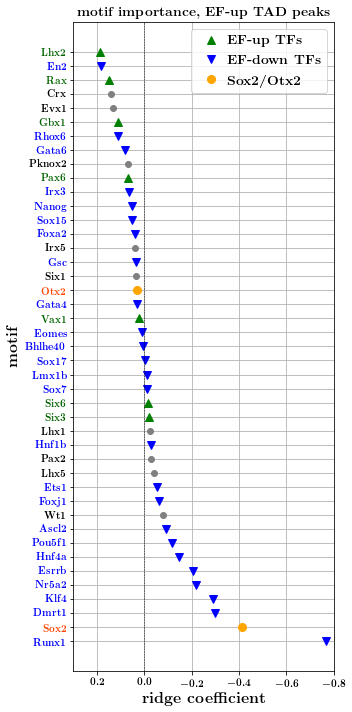

In [33]:
###################################
## motif importance in EFup TADs ##
###################################

sort_idx = np.argsort(logreg_35p_coefs_mean)#[::-1]

plt_motifs = list(np.array(collapsed_motif_names)[sort_idx])
plt_tfs = [r'\bf '+tf for tf in plt_motifs]

plt.figure(figsize=(5,10))

xpts = np.arange(len(collapsed_motif_names))


bool_in_efup_tfs   = np.in1d(np.array(plt_motifs),rna_df['ext_gene'][rna_df['EF-up']].tolist())
bool_in_efdown_tfs = np.in1d(np.array(plt_motifs),rna_df['ext_gene'][rna_df['EF-down']].tolist())
bool_in_ef_related_tfs = np.in1d(np.array(plt_motifs),['Sox2','Otx2'])
bool_other = (~bool_in_efup_tfs) & (~bool_in_efdown_tfs) & (~bool_in_ef_related_tfs)
plt.plot(logreg_35p_coefs_mean[sort_idx][bool_other],xpts[bool_other],'o',color='Gray')
plt.plot(logreg_35p_coefs_mean[sort_idx][bool_in_efup_tfs],xpts[bool_in_efup_tfs],
         '^',markersize=8,color='Green',label=r'\bf EF-up TFs')
plt.plot(logreg_35p_coefs_mean[sort_idx][bool_in_efdown_tfs],xpts[bool_in_efdown_tfs],
         'v',markersize=8,color='Blue',label=r'\bf EF-down TFs')
plt.plot(logreg_35p_coefs_mean[sort_idx][bool_in_ef_related_tfs],xpts[bool_in_ef_related_tfs],
         'o',markersize=8,color='Orange',label=r'\bf Sox2/Otx2')
plt.plot()

plt.yticks(range(len(collapsed_motif_names)),plt_tfs,fontsize=10)

ax = plt.gca()
## color EF-up genes ##
for gene in rna_df['ext_gene'][rna_df['EF-up']].tolist():
    if gene in plt_motifs:
        gene_coef_idx = plt_motifs.index(gene)
        ax.get_yticklabels()[gene_coef_idx].set_color('darkgreen')
        
for gene in rna_df['ext_gene'][rna_df['EF-down']].tolist():
    if gene in plt_motifs:
        gene_coef_idx = plt_motifs.index(gene)
        ax.get_yticklabels()[gene_coef_idx].set_color('Blue')
        
for gene in ['Sox2','Otx2']:
    if gene in plt_motifs:
        gene_coef_idx = plt_motifs.index(gene)
        ax.get_yticklabels()[gene_coef_idx].set_color('OrangeRed')



plt.axvline(0,ls='--',lw=0.5,color='Black')
plt.xlim(0.3,-0.8)
plt.xlabel(r'\bf ridge coefficient',fontsize=16)
plt.ylabel(r'\bf motif',fontsize=16)
plt.title(r'\bf motif importance, EF-up TAD peaks',fontsize=14)
plt.legend(fontsize=14,loc='upper right',handletextpad=0.2)

plt.grid()
plt.tight_layout()
plt_str = '04_atac-peaks-motif-logreg-importance-EFup_TAD_peaks.pdf'
#print(plt_str)
#plt.savefig('./figures_paper/'+plt_str)
plt.show()

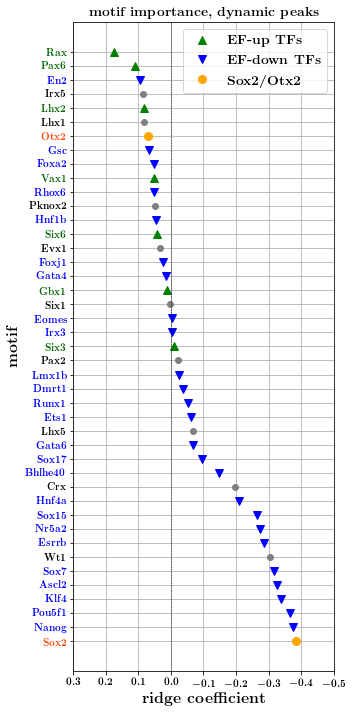

In [34]:
#######################################
## motif importance in dynamic peaks ##
#######################################

sort_idx = np.argsort(logreg_dyn_coefs_mean)#[::-1]

plt_motifs = list(np.array(dyn_collapsed_motif_names)[sort_idx])
plt_tfs = [r'\bf '+tf for tf in plt_motifs]

plt.figure(figsize=(5,10))

xpts = np.arange(len(dyn_collapsed_motif_names))

bool_in_efup_tfs   = np.in1d(np.array(plt_motifs),rna_df['ext_gene'][rna_df['EF-up']].tolist())
bool_in_efdown_tfs = np.in1d(np.array(plt_motifs),rna_df['ext_gene'][rna_df['EF-down']].tolist())
bool_in_ef_related_tfs = np.in1d(np.array(plt_motifs),['Sox2','Otx2'])
bool_other = (~bool_in_efup_tfs) & (~bool_in_efdown_tfs) & (~bool_in_ef_related_tfs)
plt.plot(logreg_dyn_coefs_mean[sort_idx][bool_other],xpts[bool_other],'o',color='Gray')
plt.plot(logreg_dyn_coefs_mean[sort_idx][bool_in_efup_tfs],xpts[bool_in_efup_tfs],
         '^',markersize=8,color='Green',label=r'\bf EF-up TFs')
plt.plot(logreg_dyn_coefs_mean[sort_idx][bool_in_efdown_tfs],xpts[bool_in_efdown_tfs],
         'v',markersize=8,color='Blue',label=r'\bf EF-down TFs')
plt.plot(logreg_dyn_coefs_mean[sort_idx][bool_in_ef_related_tfs],xpts[bool_in_ef_related_tfs],
         'o',markersize=8,color='Orange',label=r'\bf Sox2/Otx2')
plt.plot()

plt.yticks(range(len(collapsed_motif_names)),plt_tfs,fontsize=10)

ax = plt.gca()
## color EF-up genes ##
for gene in rna_df['ext_gene'][rna_df['EF-up']].tolist():
    if gene in plt_motifs:
        gene_coef_idx = plt_motifs.index(gene)
        ax.get_yticklabels()[gene_coef_idx].set_color('darkgreen')
        
for gene in rna_df['ext_gene'][rna_df['EF-down']].tolist():
    if gene in plt_motifs:
        gene_coef_idx = plt_motifs.index(gene)
        ax.get_yticklabels()[gene_coef_idx].set_color('Blue')
        
for gene in ['Sox2','Otx2']:
    if gene in plt_motifs:
        gene_coef_idx = plt_motifs.index(gene)
        ax.get_yticklabels()[gene_coef_idx].set_color('OrangeRed')


plt.axvline(0,ls='--',lw=0.5,color='Black')
plt.xlim(0.3,-0.5)
plt.xlabel(r'\bf ridge coefficient',fontsize=16)
plt.ylabel(r'\bf motif',fontsize=16)
plt.title(r'\bf motif importance, dynamic peaks',fontsize=14)
plt.legend(fontsize=14,loc='upper right')

plt.grid()
plt.tight_layout()
plt_str = '04_atac-peaks-motif-logreg-importance-dynamic_peaks.pdf'
#print(plt_str)
#plt.savefig('./figures_paper/'+plt_str)
plt.show()